In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit as cf
import os
import pandas as pd
from math import floor
import scipy.stats as stats

In [2]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['font.size'] = 15
mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['axes.axisbelow'] = True

In [3]:
dcmls = lambda x : -int(floor(np.log10(abs(x))))

round_error = lambda value,rounder : np.round(value,dcmls(rounder))

def chi2(y,y_err,x,func,popt):
    y_ajuste = func(x,*popt)
    chi_cuadrado = np.sum(((y-y_ajuste)/y_err)**2)
    return chi_cuadrado

def chi2_red(y,y_err,x,func,popt):
    chi_cuadrado = chi2(y,y_err,x,func,popt)
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    chi_reducido = chi_cuadrado/grados_lib
    return chi_reducido

def pvalue(y,y_err,x,func,popt):
    chi_cuadrado = chi2(y,y_err,x,func,popt)
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    pvalor = stats.chi2.sf(chi_cuadrado,grados_lib)
    return pvalor

In [4]:
import imageio.v3 as imageio # importar imágenes
from scipy import fft # hacer transformadas
from scipy.signal import find_peaks # para picos 1D (calibración)
from findpeaks import findpeaks # para picos 2D
fp = findpeaks(method='topology', whitelist=['peak']) # elijo este método del findpeaks

## Varilla

In [5]:
# para la barra
pesas = {'gancho':1.6949,1:20.0513,2:9.9358,3:5.1120,4:10.0746,5:10.1283,6:7.7091,7:6.4326,8:4.7368,'5F':16.0065} #gramos

pesos = np.array([0,
                  pesas[2],
                  pesas[3],
                  pesas[4],
                  pesas[6],
                  pesas[2]+pesas[3],
                  pesas[3]+pesas[4],
                  pesas[4]+pesas[5],
                  pesas[6]+pesas[8],
                  pesas[7]+pesas[6],
                  pesas[2]+pesas[3]+pesas[4]
                 ]) + pesas['gancho']
print(len(pesos))

11


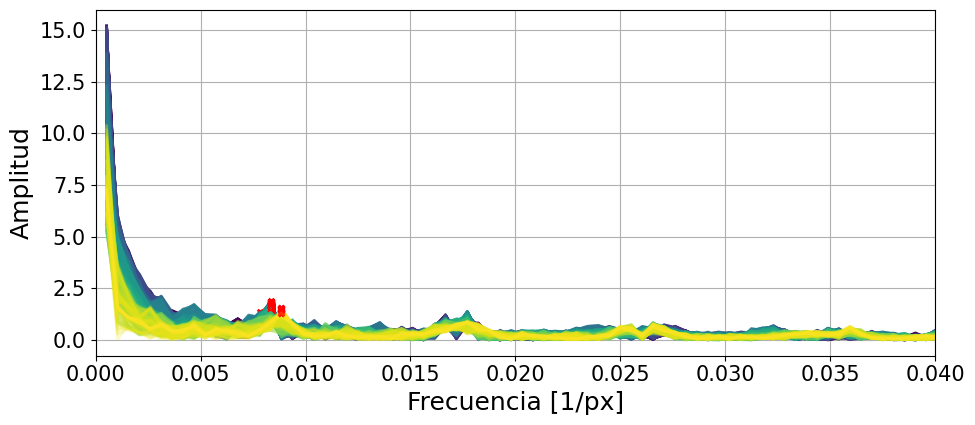

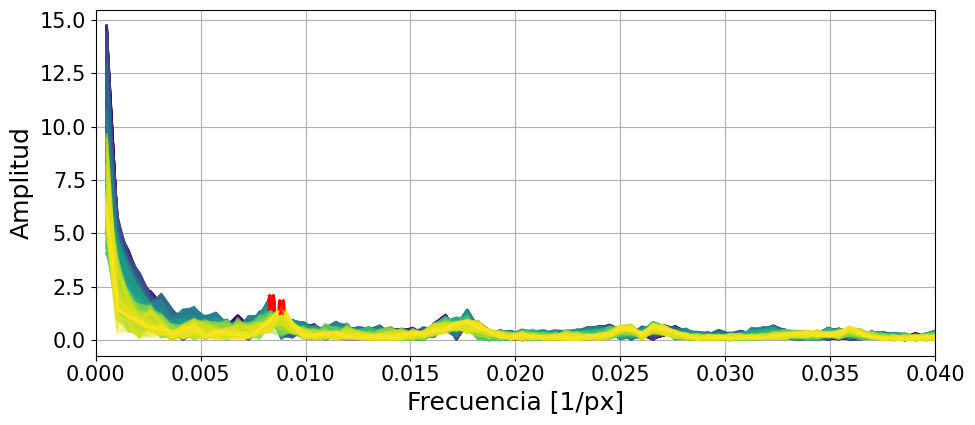

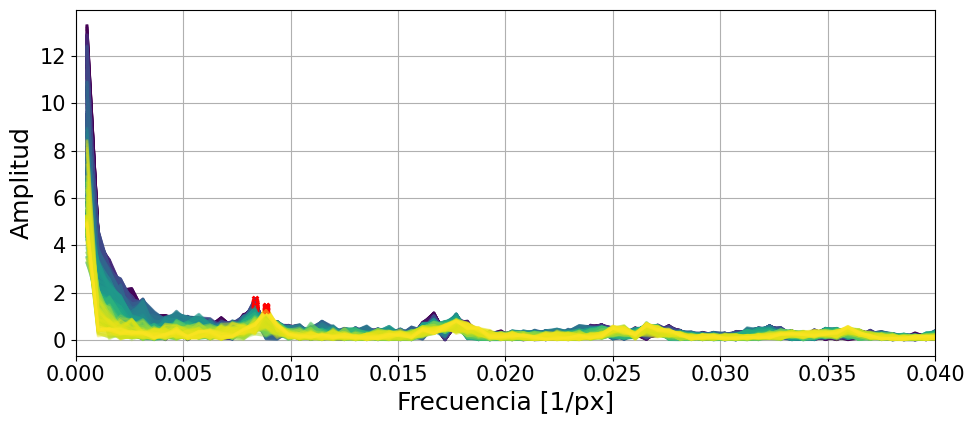

[0.00837399318463445, 0.008390567765567765, 0.008429621848739495]
[0.00026041666666666666, 0.0002605484973302601, 0.0002614587388130957]
119.07510650141097 3.707192340987745


In [170]:
maximos = []
maximos_err = []
for i in range(3):
    imagen = imageio.imread('calib_barra_2.png')[:,:,i]
    maximos_c = []

    N = max(imagen.shape)
    length = min(imagen.shape)
    a=1
    plt.figure(figsize=[10,4.5])
    for i in range(length):
        fft_result = fft.fft(imagen[:,i])    
        frec = np.arange(1,N//2)/(N)
        spec = np.abs(fft_result[1:N//2])/N
        spec_range = spec[frec<0.01]
        frec_range = frec[frec<0.01]
        spec_range = spec_range[frec_range>0.006]
        frec_range = frec_range[frec_range>0.006]
        picos, _ = find_peaks(spec_range, height = 1, prominence=1,distance = 50)
        
        plt.scatter(frec_range[picos], spec_range[picos], marker='x', c='r',zorder=2)
        plt.plot(frec, spec, color = plt.cm.viridis(i/length), label=f'Fila {i}', alpha=a)
        a = a - 0.8/length

        if len(picos) > 0:
            maximos_c.append(frec_range[picos][0])
        if len(picos) > 1:
            print(frec_range[picos])
    maximos.append(np.mean(maximos_c))
    maximos_err.append(np.sqrt(np.std(maximos)**2+np.mean(np.diff(frec))**2/4))
    
    plt.xlabel('Frecuencia [1/px]', fontsize=18)
    plt.ylabel('Amplitud', fontsize=18)
    plt.xlim(0,.04)
    plt.grid()
    plt.tight_layout()
    plt.savefig('plots/calibracion.png')
    plt.show()

print(maximos)
print(maximos_err)
maximo_cal = np.mean(maximos)
err_maximo_cal = np.sqrt(np.std(maximos)**2+np.mean(np.diff(frec)**2/4)) # error estadístico más la resolución de la transformada de Fourier

converter = 1/maximo_cal
err_converter = abs(err_maximo_cal/maximo_cal**2)
print(converter,err_converter)
px_to_cm = lambda px : 0.5*px/converter
err_px_to_cm = lambda px,err_px : np.sqrt((err_converter*0.5*px/converter**2)**2+(err_px*0.5/converter)**2)

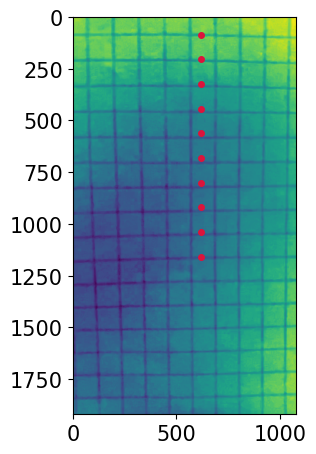

In [166]:
imagen = imageio.imread('calib_barra_2.png')[:,:,0]
plt.imshow(imagen) #todo esto de abajo es para ver qué líneas tomar para no usar las partes pintadas
#plt.axvline(350)
#plt.axvline(460)
#plt.axvline(480)
#plt.axvline(560)
#plt.axvline(710)
#plt.axvline(790)
#plt.axhline(20)
ys = 86 + np.arange(0,10)*converter
plt.scatter(np.zeros(10)+620,ys,c='crimson',zorder=3) # para ver que tan bien quedó la medicion del largo de cuadradito en píxeles

In [7]:
from scipy.ndimage import gaussian_filter

In [94]:
files = os.listdir('images/luz prendida 2/0')
names = []
for file in files:
    if file.endswith('.png'):
        names.append(file)
names = sorted(names) # en orden alfabético para que coincidan con los pesos

maximos = []
err_maximos = []
imagenes = []
espectros = []
peaks_espectros = []

for i,name in enumerate(names):
    imagen = imageio.imread(f'images/luz prendida 2/0/{name}')[:,750:].transpose() # recorto y pongo en horizontal

    fufu = fft.fft2(imagen)
    fufu_centrada = fft.fftshift(fufu)  # pongo el 0 en el centro de la imagen
    espectro = np.abs(fufu_centrada)
    espectro = gaussian_filter(espectro,sigma=1)
    espectro = espectro/np.max(espectro)*255 # normalizo
    freqs_x = fft.fftshift(fft.fftfreq(espectro.shape[0])) # frecuencias en x del espectro
    freqs_y = fft.fftshift(fft.fftfreq(espectro.shape[1])) # frecuencias en y del espectro

    results = fp.fit(espectro) # calculo los picos
    peak_coordinates = results['Xdetect'] # estos son los valores que necesito, me devuelve un objeto con otras cosas al pedo

    imagenes.append(imagen)
    espectros.append(espectro)
    peaks_espectros.append(peak_coordinates)

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at -1.
[findpeaks] >Fin.
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at -1.
[findpeaks] >Fin.
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology

In [33]:
which_peak = [[1,2],[1,2],[1,2],[1,2],[1,2],[1,2],None,None,[1,2],[1,2],None]
print(len(which_peak))
print(len(imagenes))

11
11


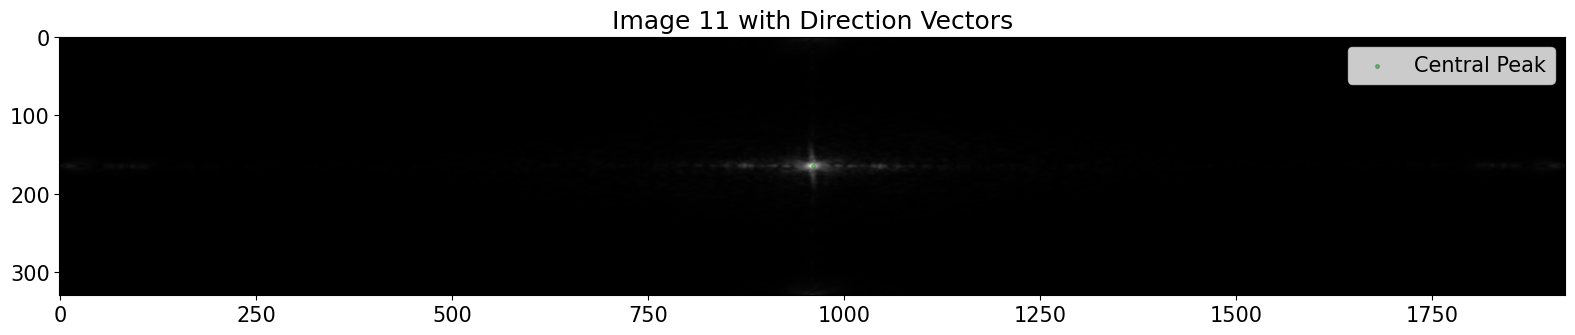

In [106]:
# Acá hay que ver cual de los picos secundarios es el correcto, lo importante es la dirección (perpendicular al patrón)
# y el valor de la frecuencia (que corresponda a un período del patrón)

colormap = mpl.cm.get_cmap('tab10')

quiero = 'espectro'
#quiero='imagen'

i = 10
imagen = imagenes[i]
espectro = espectros[i]
peak_coordinates = peaks_espectros[i]
freqs_x = fft.fftshift(fft.fftfreq(espectro.shape[1])) # calculo las frecuencias, acá estoy usando los arrays que guardé en la celda anterior
freqs_y = fft.fftshift(fft.fftfreq(espectro.shape[0]))

plt.figure(figsize=(16, 8))
if quiero == 'imagen':
    plt.imshow(imagen, cmap='gray')  # ploteo la imagen para tener en el fondo y comparar
if quiero == 'espectro':
    plt.imshow(np.log(1+espectro), cmap='gray')  # ploteo la transformada para tener en el fondo y comparar

max_index = np.unravel_index(np.argmax(peak_coordinates, axis=None), peak_coordinates.shape) # calculo la posición del pico central

flat_array = peak_coordinates.flatten() # convierto en un array 1D para recorrer más fácil
sorted_indices = np.argsort(flat_array)[::-1] # ordeno de mayor a menor

plt.scatter(max_index[1], max_index[0], c='forestgreen', s=7, alpha=0.5, label='Central Peak') # ploteo posición del máximo central

for j, idx in enumerate(sorted_indices[1:], 1): # recorro las posiciones de mayor a menor
    if flat_array[idx] < 0.1: # me quedo con los picos con una cierta altura
        continue
#    if j < 2: # salteo los que no quiero a ojo
#        continue
    max_index_2 = np.unravel_index(idx, peak_coordinates.shape)
    
    freq_x = freqs_x[max_index_2[1]] - freqs_x[max_index[1]] # calculo la frecuencia correspondiente a ese pico
    freq_y = freqs_y[max_index_2[0]] - freqs_y[max_index[0]]
    print(freq_x,freq_y)

    freq = np.sqrt(freq_x**2+freq_y**2) # calculo el modulo de la frecuencia 2D
    direction = np.array([freq_x,freq_y])/freq # calculo la direccion de la frecuencia 2D
    d_dist = 1/freq
    dist_vector = d_dist*direction # genero un vector con modulo longitud de onda y la misma dirección que la frecuencia
    print(dist_vector)

    x_start, y_start = max_index[1], max_index[0]
    x_end, y_end = x_start + dist_vector[0], y_start + dist_vector[1] # calculo los puntos de inicio y final del vector dirección con módulo longitud de onda

    color = colormap(j % colormap.N)
    if quiero == 'espectro':
        plt.scatter(max_index_2[1],max_index_2[0],alpha=0.8,label=f'Peak {j}')
        plt.xlim(800,1125)
        plt.ylim(100,210)
    if quiero == 'imagen':
        plt.scatter(x_end, y_end, c=color, s=7, alpha=0.5, label=f'Peak {j}')
        plt.plot([x_start, x_end], [y_start, y_end], '-', color=color, alpha=0.5) # ploteo el vector
        #plt.xlim(800,1100)

plt.legend()
plt.title(f'Image {i+1} with Direction Vectors')

plt.tight_layout()
plt.show()
plt.close()

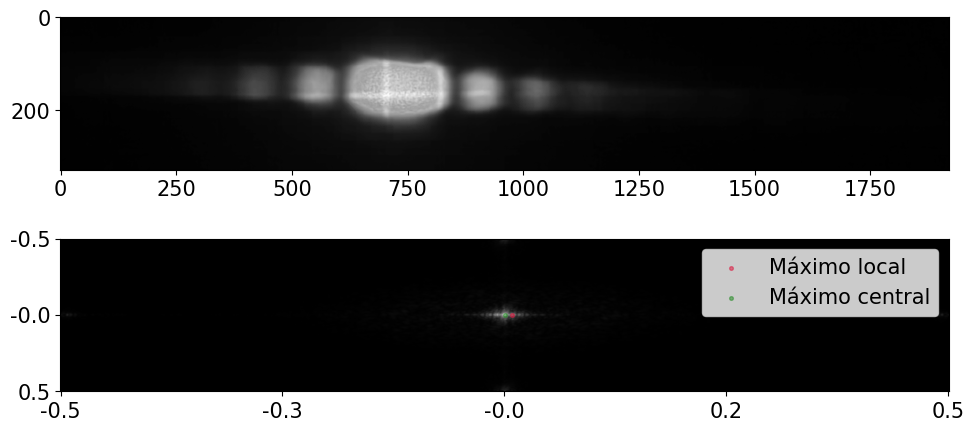

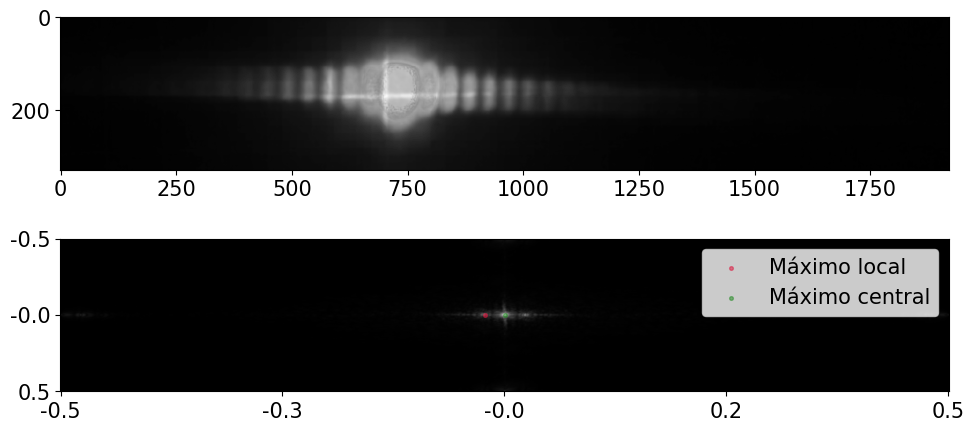

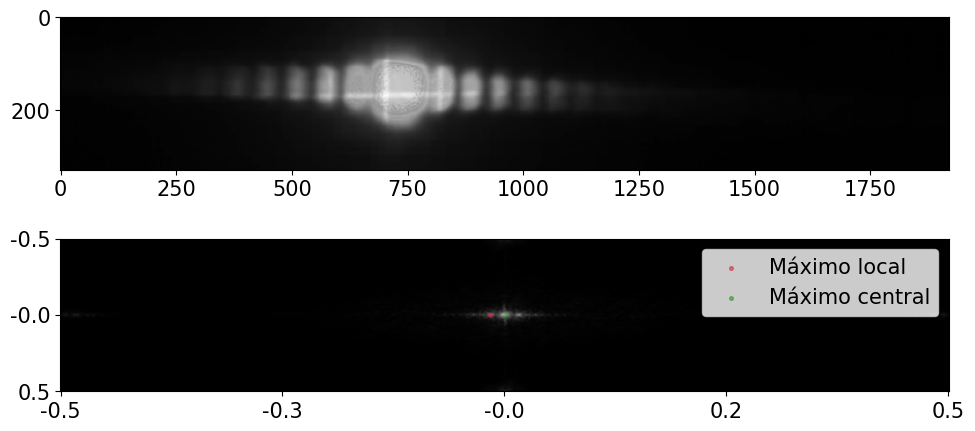

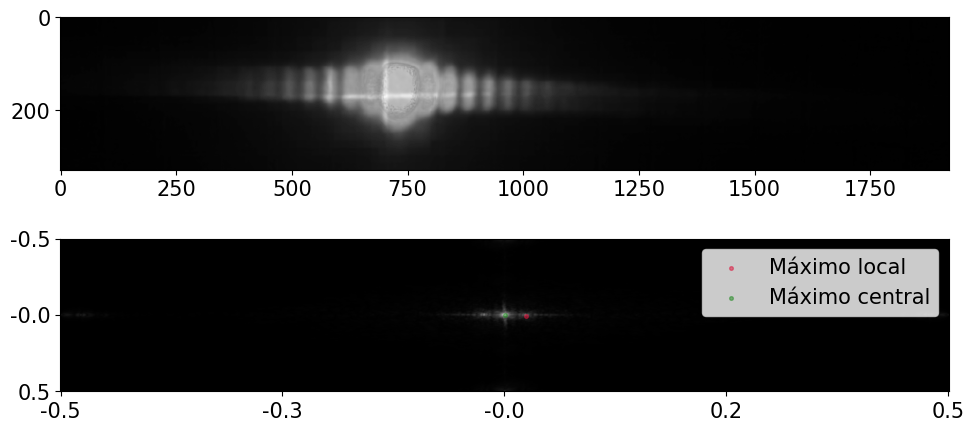

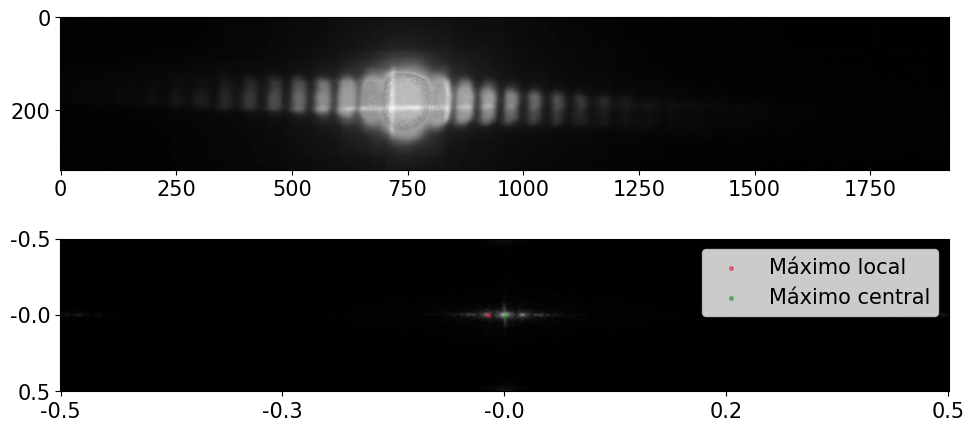

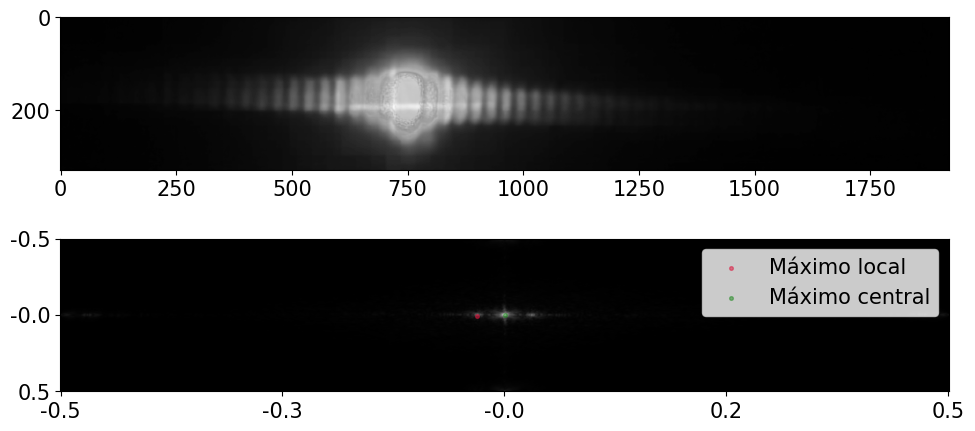

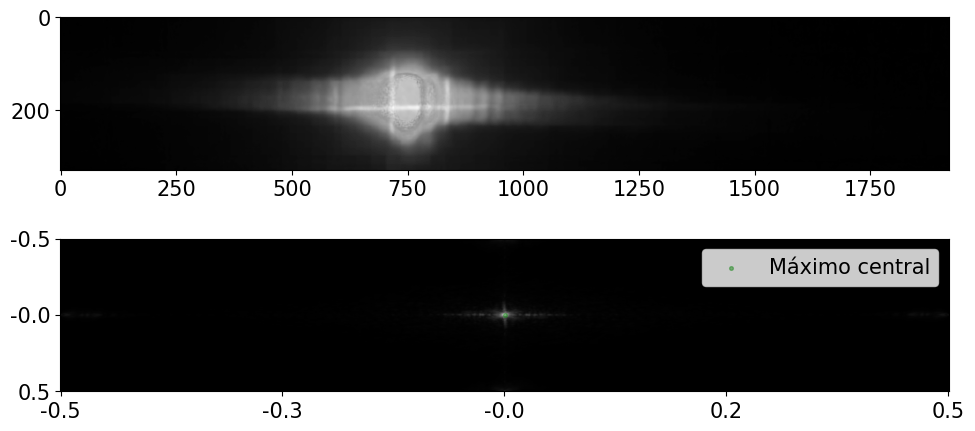

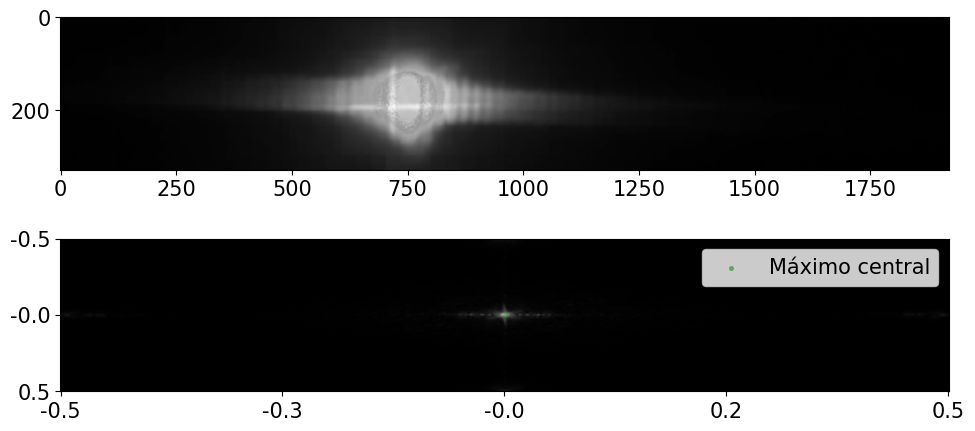

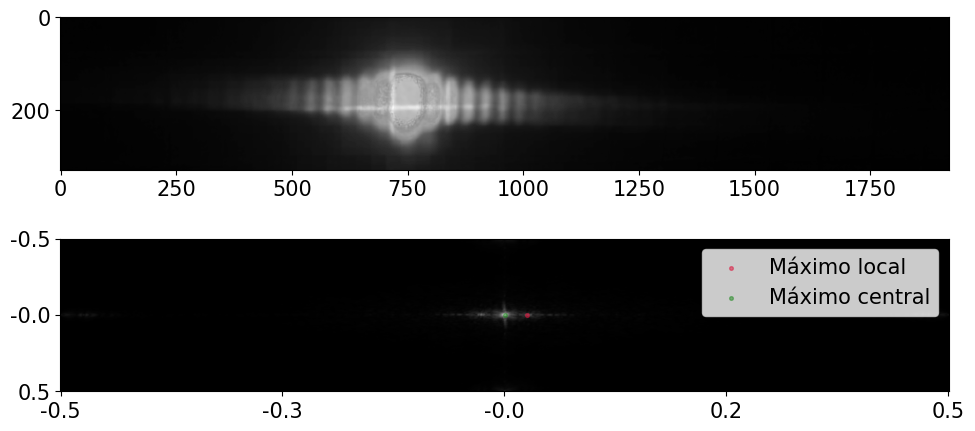

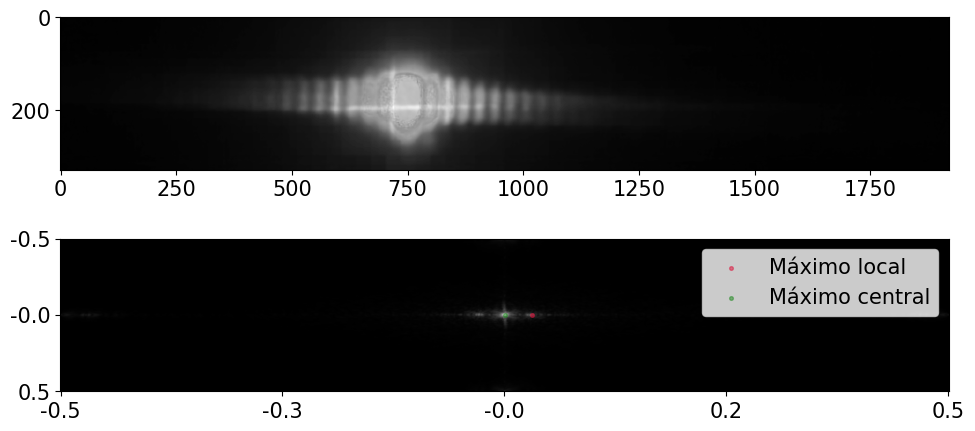

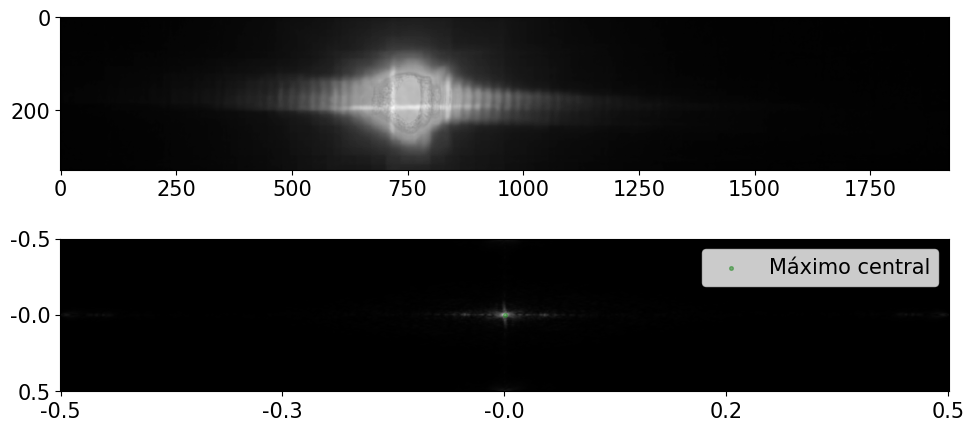

In [112]:
maximos = []
err_maximos = []
for i in range(len(imagenes)):
    imagen = imagenes[i]
    espectro = espectros[i]
    peak_coordinates = peaks_espectros[i]
    
    max_index = np.unravel_index(np.argmax(peak_coordinates, axis=None), peak_coordinates.shape) # pico central

    flat_array = peak_coordinates.flatten()
    sorted_indices = np.argsort(flat_array)[::-1]

    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.imshow(imagen, cmap='gray') # ploteo la imagen
    plt.tight_layout()
    
    indexs = which_peak[i]
    if indexs is not None:
        maxs = []
        for j in indexs:
            max_index_2 = np.unravel_index(sorted_indices[j+1], peak_coordinates.shape) # segundo pico, corresponde al que nos interesa
            freq_x = freqs_x[max_index_2[1]]-freqs_x[max_index[1]] # valor del máximo en x 
            freq_y = freqs_y[max_index_2[0]]-freqs_y[max_index[0]] # valor del máximo en y

            err_x = np.mean(np.diff(freqs_x))/2
            err_y = np.mean(np.diff(freqs_y))/2
            err_tot = np.sqrt((freq_x**2*err_x**2+freq_y**2*err_y**2)/(freq_x**2+freq_y**2))
            
            freq_tot = np.sqrt(freq_x**2+freq_y**2) # valor absoluto del máximo
            maxs.append(freq_tot)
        maximos.append(np.mean(maxs))
        err_maximos.append(np.sqrt(np.std(maxs)**2+err_tot**2))
        max_index_2 = np.unravel_index(sorted_indices[indexs[0]+1], peak_coordinates.shape)
    else:
        maximos.append(np.nan)
        err_maximos.append(np.nan)
        max_index_2 = None
    
    plt.subplot(2,1, 2)
    plt.imshow(np.log(espectro + 1), cmap='gray')  # ploteo la transformada en escala logarítmica para que se vea algo
    if max_index_2 is not None:
        plt.scatter(max_index_2[1],max_index_2[0],c='crimson',s=7,alpha=0.5,label='Máximo local')
    plt.scatter(max_index[1],max_index[0],c='forestgreen',s=7,alpha=0.5,label='Máximo central')
    plt.legend()

    valid_xticks = np.array([1,1920/4,1920/2,3*1920/4,1920])-1 # pongo ticks en esos valores
    valid_yticks = np.array([1,330/2,330])-1
    new_xtick_labels = [f'{freqs_x[int(tick)]:.1f}' for tick in valid_xticks] # los renombro al valor de la frecuencia
    new_ytick_labels = [f'{freqs_y[int(tick)]:.1f}' for tick in valid_yticks]
    
    plt.gca().set_xticks(valid_xticks)
    plt.gca().set_xticklabels(new_xtick_labels)
    plt.gca().set_yticks(valid_yticks)
    plt.gca().set_yticklabels(new_ytick_labels)

    plt.tight_layout()
    plt.show()
    plt.close()

[0.0125, 0.026091724834159793, 0.019925179709361994, 0.025145228111029008, 0.02269433136503167, 0.03020031857557921, nan, nan, 0.023865214536876893, 0.030259426318963452, nan]
[ 1.6949 11.6307  6.8069 11.7695  9.404  16.7427 16.8815 21.8978 14.1408
 15.8366 26.8173]


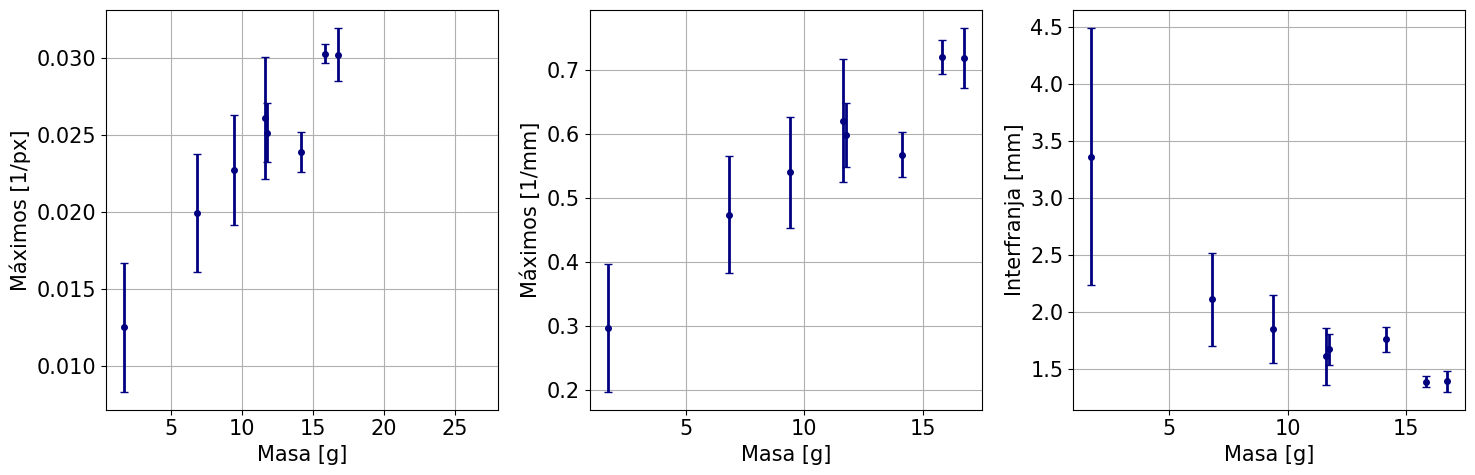

In [113]:
print(maximos)
interfranjas = px_to_cm(1/np.array(maximos))*10
err_interfranjas = err_px_to_cm(1/np.array(maximos),np.array(err_maximos)/np.array(maximos)**2)*10

inv_interfranjas = 1/interfranjas
err_inv_interfranjas = err_interfranjas/interfranjas**2
print(pesos)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(pesos,maximos,c='navy',zorder=2)
plt.errorbar(pesos,maximos,yerr=err_maximos,fmt='none',ecolor='navy',label='Datos',zorder=1)
plt.grid()
plt.xlabel('Masa [g]')
plt.ylabel('Máximos [1/px]')

plt.subplot(1,3,2)
plt.scatter(pesos,inv_interfranjas,c='navy',zorder=2)
plt.errorbar(pesos,inv_interfranjas,yerr=err_inv_interfranjas,fmt='none',ecolor='navy',label='Datos',zorder=1)
plt.grid()
plt.xlabel('Masa [g]')
plt.ylabel('Máximos [1/mm]')

plt.subplot(1,3,3)
plt.scatter(pesos,interfranjas,c='navy',zorder=2)
plt.errorbar(pesos,interfranjas,yerr=err_interfranjas,fmt='none',ecolor='navy',label='Datos',zorder=1)
plt.grid()
plt.xlabel('Masa [g]')
plt.ylabel('Interfranja [mm]')
plt.show()
plt.close()

In [13]:
lineal = lambda x,a,b : a*x+b

[ 1.6949 11.6307  6.8069 11.7695  9.404  16.7427 16.8815 21.8978 14.1408
 15.8366 26.8173]
[0.29768777 0.62137498 0.47451858 0.59883414 0.54046598 0.71922123
        nan        nan 0.56835059 0.72062888        nan]
[0.02788599 0.27312295]
[2.86886902e-05 5.98145064e-03]


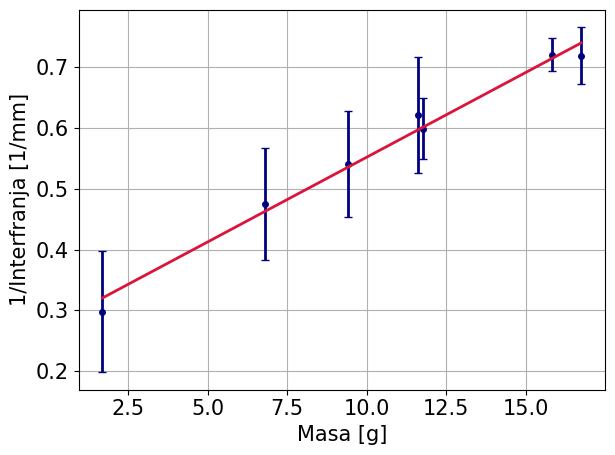

In [125]:
sorting_idx = np.argsort(pesos)

s_pesos = []
s_inv_interfranjas = []
s_err_inv_interfranjas = []
s_interfranjas = []
s_err_interfranjas = []

for i in sorting_idx:
    if i == 8:
        continue
    if not np.isnan(inv_interfranjas[i]):
        s_pesos.append(pesos[i])
        s_inv_interfranjas.append(inv_interfranjas[i])
        s_err_inv_interfranjas.append(err_inv_interfranjas[i])

print(pesos)
print(inv_interfranjas)

pars,cov = cf(lineal,s_pesos,s_inv_interfranjas,absolute_sigma=True,sigma=s_err_inv_interfranjas)
print(pars)
print(np.diag(cov))

x_adj = np.linspace(min(s_pesos),max(s_pesos))
y_adj = lineal(x_adj,*pars)

plt.scatter(s_pesos,s_inv_interfranjas,c='navy',zorder=2)
plt.errorbar(s_pesos,s_inv_interfranjas,yerr=s_err_inv_interfranjas,fmt='none',ecolor='navy',label='Datos',zorder=1)
plt.plot(x_adj,y_adj,c='crimson',label='Ajuste',zorder=3)
plt.grid()
plt.xlabel('Masa [g]')
plt.ylabel(r'1/Interfranja [1/mm]')

plt.savefig('plots/young_transformada.png')

In [126]:
print(chi2_red(np.array(s_inv_interfranjas),np.array(s_err_inv_interfranjas),np.array(s_pesos),lineal,pars))
print(pvalue(np.array(s_inv_interfranjas),np.array(s_err_inv_interfranjas),np.array(s_pesos),lineal,pars))

0.09553153403848426
0.9839139595635549


In [168]:
D = 142.5*10 # mm, distancia de la rendija a la pantalla
err_D = 1
l = 670*1e-9*1000 # mm, longitud de onda del láser
g =  9.79688239*1000 # mm/s**2 aceleracion de la gravedad
d = 5 # mm, diametro de la barra
err_d = 0.01
L = 41.5*10 # mm largo de la barra
err_L = 0.1*10

young = lambda beta : 64*g/(3*np.pi*l) * L**3/(beta*d**4*D)
err_young = lambda beta, err_beta : 64*g/(3*np.pi*l) * np.sqrt((3*L**2/(beta*d**4*D)*err_L)**2 + (L**3/(beta**2*d**4*D)*err_beta)**2 + (4*L**3/(beta*d**5*D)*err_d)**2 + (L**3/(beta*d**4*D**2)*err_D)**2)

In [64]:
import likefit

0
Fit summary
Estimators: [0.27312295 0.02788599]
Errors: [0.07733984 0.00535618]
Covariance matrix: [[ 5.98145060e-03 -4.01270822e-04]
 [-4.01270822e-04  2.86886907e-05]]
Correlation matrix: [[ 1.         -0.96867693]
 [-0.96867693  1.        ]]
Chi square: 0.38212613615393654
Degrees of freedom: 5
Pvalue: 0.9958076360763429


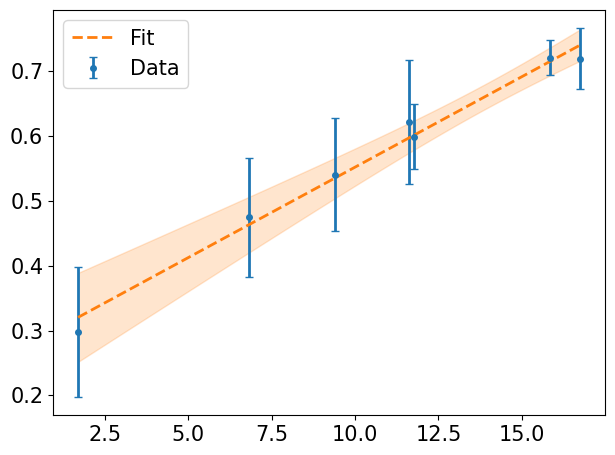

In [127]:
def fit_model(x: np.array, par: np.array) -> np.array:
    return par[0] + par[1] * x
fitter = likefit.LinearLeastSquares(np.array(s_pesos),np.array(s_inv_interfranjas), fit_model, np.array(s_err_inv_interfranjas))
fit_status = fitter.fit()
print(fit_status)
fitter.print_results()
estimators = fitter.get_estimators()
fig, ax = plt.subplots()
fitter.plot_fit(ax=ax)
# Save the current figure in pdf, eps, svg, and png format
# danatools.savefigs("linear_least_squares")

In [69]:
estimators

array([0.14606196, 0.01240521])

In [169]:
print(young(estimators[1])/10**9,err_young(estimators[1],0.00535618)/10**9)

285.74937026092556 54.971865812520306


In [162]:
pesos[4]

9.404

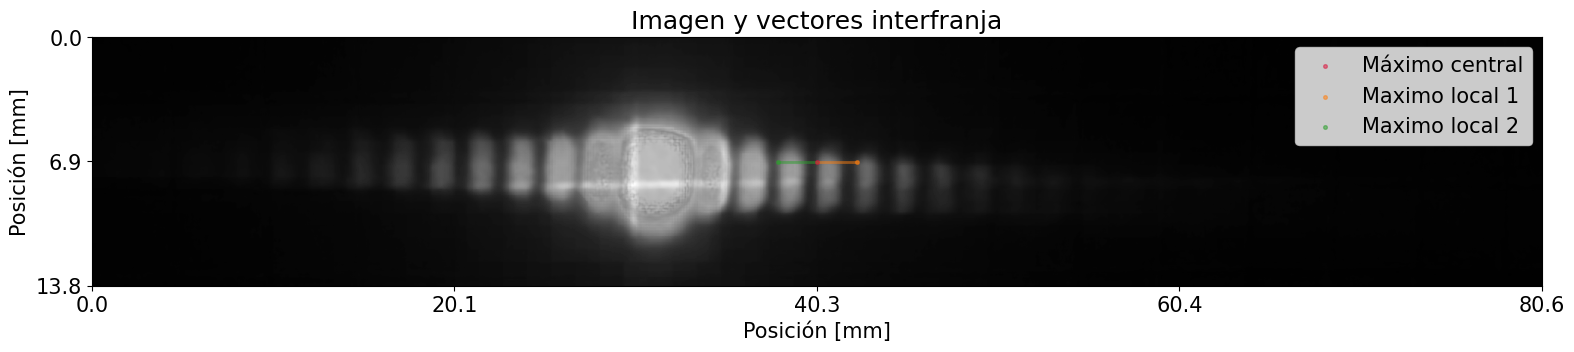

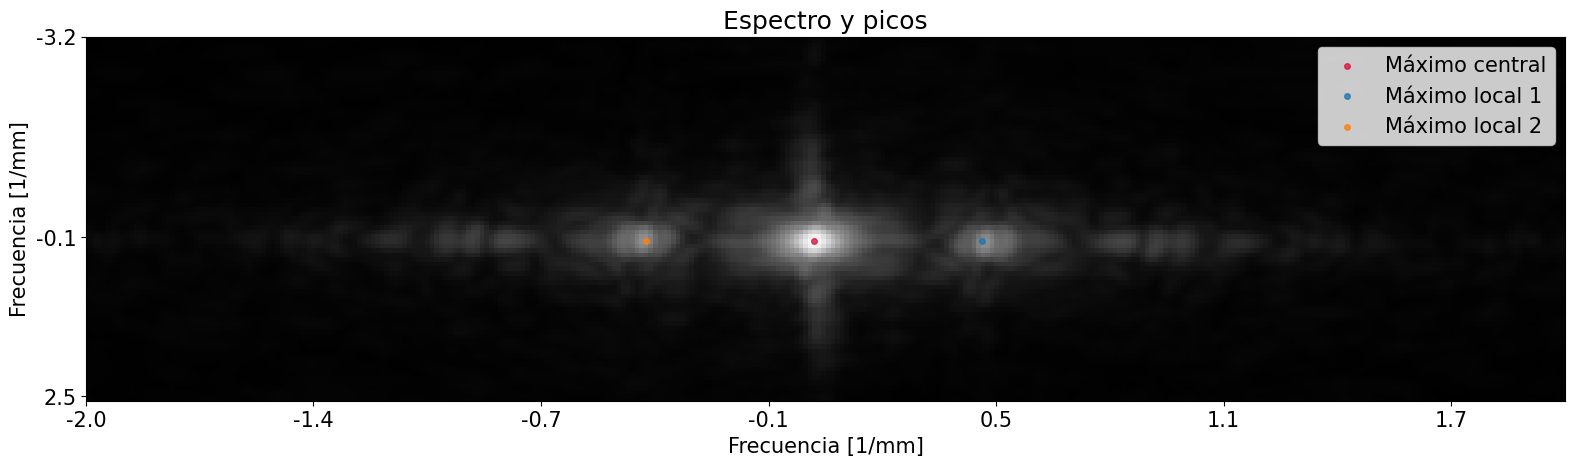

In [163]:
i = 4
imagen = imagenes[i]
espectro = espectros[i]
peak_coordinates = peaks_espectros[i]
freqs_x = fft.fftshift(fft.fftfreq(espectro.shape[1])) # calculo las frecuencias, acá estoy usando los arrays que guardé en la celda anterior
freqs_y = fft.fftshift(fft.fftfreq(espectro.shape[0]))

plt.figure(figsize=(16, 8))
plt.imshow(imagen, cmap='gray')  # ploteo la imagen para tener en el fondo y comparar

max_index = np.unravel_index(np.argmax(peak_coordinates, axis=None), peak_coordinates.shape) # calculo la posición del pico central

flat_array = peak_coordinates.flatten() # convierto en un array 1D para recorrer más fácil
sorted_indices = np.argsort(flat_array)[::-1] # ordeno de mayor a menor

plt.scatter(max_index[1], max_index[0], c='crimson', s=7, alpha=0.5, label='Máximo central',zorder=5) # ploteo posición del máximo central

for j, idx in enumerate(sorted_indices[1:], 1): # recorro las posiciones de mayor a menor
    if flat_array[idx] < 1: # me quedo con los picos con una cierta altura
        continue
    max_index_2 = np.unravel_index(idx, peak_coordinates.shape)
    
    freq_x = freqs_x[max_index_2[1]] - freqs_x[max_index[1]] # calculo la frecuencia correspondiente a ese pico
    freq_y = freqs_y[max_index_2[0]] - freqs_y[max_index[0]]

    freq = np.sqrt(freq_x**2+freq_y**2) # calculo el modulo de la frecuencia 2D
    direction = np.array([freq_x,freq_y])/freq # calculo la direccion de la frecuencia 2D
    d_dist = 1/freq
    dist_vector = d_dist*direction # genero un vector con modulo longitud de onda y la misma dirección que la frecuencia

    x_start, y_start = max_index[1], max_index[0]
    x_end, y_end = x_start + dist_vector[0], y_start + dist_vector[1] # calculo los puntos de inicio y final del vector dirección con módulo longitud de onda

    color = colormap(j % colormap.N)
    plt.scatter(x_end, y_end, c=color, s=7, alpha=0.5, label=f'Maximo local {j}')
    plt.plot([x_start, x_end], [y_start, y_end], '-', color=color, alpha=0.5) # ploteo el vector
    #plt.xlim(800,1100)

valid_xticks = np.array([1,1920/4,1920/2,3*1920/4,1920])-1 # pongo ticks en esos valores
valid_yticks = np.array([1,330/2,330])-1
new_xtick_labels = [f'{px_to_cm(tick)*10:.1f}' for tick in valid_xticks] # los renombro al valor de la frecuencia
new_ytick_labels = [f'{px_to_cm(tick)*10:.1f}' for tick in valid_yticks]

plt.gca().set_xticks(valid_xticks)
plt.gca().set_xticklabels(new_xtick_labels)
plt.gca().set_yticks(valid_yticks)
plt.gca().set_yticklabels(new_ytick_labels)

plt.legend()
plt.xlabel('Posición [mm]')
plt.ylabel('Posición [mm]')
plt.title('Imagen y vectores interfranja')
plt.tight_layout()
plt.savefig('plots/imagen.png',bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(16, 8))
plt.imshow(np.log(1+espectro), cmap='gray')  # ploteo la transformada para tener en el fondo y comparar

plt.scatter(max_index[1], max_index[0], c='crimson', alpha=0.8, label='Máximo central') # ploteo posición del máximo central

for j, idx in enumerate(sorted_indices[1:], 1): # recorro las posiciones de mayor a menor
    if flat_array[idx] < 1: # me quedo con los picos con una cierta altura
        continue
    max_index_2 = np.unravel_index(idx, peak_coordinates.shape)
    
    freq_x = freqs_x[max_index_2[1]] - freqs_x[max_index[1]] # calculo la frecuencia correspondiente a ese pico
    freq_y = freqs_y[max_index_2[0]] - freqs_y[max_index[0]]

    freq = np.sqrt(freq_x**2+freq_y**2) # calculo el modulo de la frecuencia 2D
    direction = np.array([freq_x,freq_y])/freq # calculo la direccion de la frecuencia 2D
    d_dist = 1/freq
    dist_vector = d_dist*direction # genero un vector con modulo longitud de onda y la misma dirección que la frecuencia

    x_start, y_start = max_index[1], max_index[0]
    x_end, y_end = x_start + dist_vector[0], y_start + dist_vector[1] # calculo los puntos de inicio y final del vector dirección con módulo longitud de onda

    color = colormap(j % colormap.N)
    plt.scatter(max_index_2[1],max_index_2[0],alpha=0.8,label=f'Máximo local {j}')
    plt.xlim(800,1125)
    plt.ylim(200,120)

valid_xticks = np.array([801,851,901,951,1001,1051,1101])-1 # pongo ticks en esos valores
valid_yticks = np.array([200,165,121])-1
new_xtick_labels = [f'{1/px_to_cm(1/freqs_x[int(tick)])/10:.1f}' for tick in valid_xticks] # los renombro al valor de la frecuencia
new_ytick_labels = [f'{1/px_to_cm(1/freqs_y[int(tick)])/10:.1f}' for tick in valid_yticks]

plt.gca().set_xticks(valid_xticks)
plt.gca().set_xticklabels(new_xtick_labels)
plt.gca().set_yticks(valid_yticks)
plt.gca().set_yticklabels(new_ytick_labels)

plt.tight_layout()
plt.legend()
plt.xlabel('Frecuencia [1/mm]')
plt.ylabel('Frecuencia [1/mm]')
plt.title('Espectro y picos')
plt.savefig('plots/espectro.png',bbox_inches='tight')
plt.show()
plt.close()